In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia qdrant-client==1.12.1 nest-asyncio>=1.5.0 tenacity pypdf langchain-huggingface langchain-groq


In [ ]:
from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, TextLoader, WebBaseLoader
from langchain_community.tools import TavilySearchResults
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, StateGraph
from typing import Dict, TypedDict
from langchain_core.prompts import PromptTemplate
import pprint
import yaml
import nest_asyncio
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
import tempfile
import os
#from langchain_anthropic import ChatAnthropic
from tenacity import retry, stop_after_attempt, wait_exponential
from langchain_huggingface import HuggingFaceEmbeddings
# from dotenv import load_dotenv

# load_dotenv()
from langchain_groq import ChatGroq
nest_asyncio.apply()


In [ ]:
from google.colab import userdata
qdrant_url=userdata.get('qdrant_url')
qdrant_api_key=userdata.get('qdrant_api_key')
tavily_api_key=userdata.get('tavily_api_key')

In [ ]:
import os
# Update embeddings initialization
# embeddings = OpenAIEmbeddings(
#     model="text-embedding-3-small",
#     api_key='X1232342323232'
# )
os.environ['TAVILY_API_KEY']=tavily_api_key

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
# Update Qdrant client initialization
client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key
)


@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def execute_tavily_search(tool, query):
    return tool.invoke({"query": query})


def web_search(state):
    """Web search based on the re-phrased question using Tavily API."""
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]


    try:
        if not tavily_api_key:
            print("Tavily API key is  not provided so skipping web search module")
            return {"keys": {"documents": documents, "question": question}}


        # Initialize Tavily search tool
        tool = TavilySearchResults(
            api_key=tavily_api_key,
            max_results=3,
            search_depth="advanced"
        )

        try:
            search_results = execute_tavily_search(tool, question)
        except Exception as search_error:
            print(f"Search failed after retries with follwoing error: {str(search_error)}")
            return {"keys": {"documents": documents, "question": question}}

        if not search_results:
            print("No search results found")
            return {"keys": {"documents": documents, "question": question}}

        # Process results
        web_results = []
        for result in search_results:
            # Extract and format relevant information
            content = (
                f"Title: {result.get('title', 'No title')}\n"
                f"Content: {result.get('content', 'No content')}\n"
            )
            web_results.append(content)

        # Create document from results
        web_document = Document(
            page_content="\n\n".join(web_results),
            metadata={
                "source": "web_search",
                "query": question,
                "result_count": len(web_results)
            }
        )
        documents.append(web_document)

    except Exception as error:
        error_msg = f"Web search error: {str(error)}"
        print(error_msg)
    return {"keys": {"documents": documents, "question": question}}


def load_documents(file_or_url: str, is_url: bool = True) -> list:
    try:
        if is_url:
            loader = WebBaseLoader(file_or_url)
        else:
            file_extension = os.path.splitext(file_or_url)[1].lower()
            if file_extension == '.pdf':
                loader = PyPDFLoader(file_or_url)
            elif file_extension in ['.txt', '.md']:
                loader = TextLoader(file_or_url)
            else:
                raise ValueError(f"Unsupported file type: {file_extension}")

        return loader.load()
    except Exception as e:
        print(f"Error loading document: {str(e)}")
        return []


docs = None

input_option = input("""Choose input method["URL", "File Upload"] :""")

if input_option == "URL":
    url = 'https://arxiv.org/pdf/2307.09288.pdf'
    if url:
        docs = load_documents(url, is_url=True)
else:
        docs = load_documents('/content/a_history_of_near-earth_object_research_tagged.pdf', is_url=False)
        ## Clean up the temporary file
        #os.unlink(tmp_file.name)

if docs:
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=100
    )
    all_splits = text_splitter.split_documents(docs)
    print(len(all_splits))

    client = QdrantClient(url=qdrant_url, api_key=qdrant_api_key)
    collection_name = "test-rag"

    try:
        # Try to delete the collection if it exists
        client.delete_collection(collection_name)
    except Exception:
        pass

    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    )

    # Create vectorstore
    vectorstore = Qdrant(
        client=client,
        collection_name=collection_name,
        embeddings=embeddings,
    )

    # Add documents to the vectorstore
    vectorstore.add_documents(all_splits)
    retriever = vectorstore.as_retriever()
    #retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
    print('\n\nSuccessfully stored embedding in Qdrant vector store')




Choose input method["URL", "File Upload"] :file
734


Successfully stored embedding in Qdrant vector store


Enter your question : what is  modernbert and how it is different from vanilla bert model


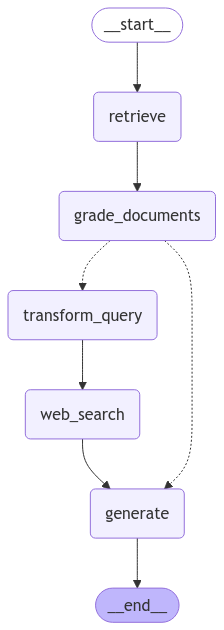

~-retrieve-~
[Document(metadata={'source': '/content/a_history_of_near-earth_object_research_tagged.pdf', 'page': 171, '_id': '6cba14a9-0d9b-447a-abfc-e34c01bce174', '_collection_name': 'test-rag'}, page_content='A History of Near-Earth Objects Research\n160\nfor a nucleus in prograde rotation or subtract orbital energy for a retrograde \nrotator.46 Brian Marsden and Zdenek Sekanina of JPL carried out a number of \nefforts to empirically model these so-called nongravitational forces acting on \ncomets in the late 1960s and early 1970s. The model introduced by Marsden, \nSekanina, and Yeomans in 1973, where the comet’s rocket-like thrusting is \nbased upon the vaporization of water ice as a function of heliocentric distance, \nwas quite successful and is still in use more than 40\xa0years later. 47\nSurprisingly, inactive asteroids are also affected by nongravitational forces. \nBecause of their “thermal inertia”—their ability to retain heat—the motions \nof asteroids are affected by th

In [30]:
import os, getpass
from IPython.display import Image, display
# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")


#llm = ChatOpenAI(model="gpt-4o")


#llm = ChatGroq(temperature=0, groq_api_key=userdata.get('groq_api_key'), model_name="llama-3.3-70b-versatile")
llm = ChatGroq(temperature=0, groq_api_key=userdata.get('groq_api_key'), model_name="llama-3.3-70b-versatile")
class GraphState(TypedDict):
    keys: Dict[str, any]


def retrieve(state):
    print("~-retrieve-~")
    state_dict = state["keys"]
    question = state_dict["question"]

    if retriever is None:
        return {"keys": {"documents": [], "question": question}}

    documents = retriever.get_relevant_documents(question)
    print(documents)
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """Generate answer using llama-3.3-70b-versatile model"""
    print("~-generate-~")
    state_dict = state["keys"]
    question, documents = state_dict["question"], state_dict["documents"]
    try:
        prompt = PromptTemplate(template="""Based on the following context, please answer the question. If you are unable  to find the information in the context, say "I am unable tp find the answer in the context"\n.
        Context: {context}\n
        Question: {question}
        Answer:""", input_variables=["context", "question"])
        context = "\n\n".join(doc.page_content for doc in documents)

        # Create and run chain
        rag_chain = (
            {"context": lambda x: context, "question": lambda x: question}

            | prompt
            | llm
            | StrOutputParser()
        )

        generation = rag_chain.invoke({})

        return {
            "keys": {
                "documents": documents,
                "question": question,
                "generation": generation
            }
        }

    except Exception as e:
        error_msg = f"Error in generate function: {str(e)}"
        print(error_msg)
        return {"keys": {"documents": documents, "question": question,
                "generation": "Sorry, I encountered an error while generating the response."}}

def grade_documents(state):
    """Determines whether the retrieved documents are relevant."""
    print("###check relevance")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]


    prompt = PromptTemplate(template="""You are grading the relevance of a retrieved document to a user question.
        Return ONLY a JSON object with a "score" field that is either "yes" or "no".
        Do not include any other text or explanation.

        Document: {context}
        Question: {question}

        Rules:
        - Check for related keywords or semantic meaning
        - Use lenient grading to only filter clear mismatches
        - Return exactly like this example: {{"score": "yes"}} or {{"score": "no"}}""",
        input_variables=["context", "question"])

    chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    filtered_docs = []
    search = "No"

    for d in documents:
        try:
            response = chain.invoke({"question": question, "context": d.page_content})
            import re
            json_match = re.search(r'\{.*\}', response)
            if json_match:
                response = json_match.group()

            import json
            score = json.loads(response)

            if score.get("score") == "yes":
                print("~-grade: document relevant-~")
                filtered_docs.append(d)
            else:
                print("~-grade: document not relevant-~")
                search = "Yes"

        except Exception as e:
            print(f"Error grading document: {str(e)}")
            # On error, keep the document to be safe
            filtered_docs.append(d)
            continue

    return {"keys": {"documents": filtered_docs, "question": question, "run_web_search": search}}


def transform_query(state):
    """Transform the query to produce a better question."""
    print("~-transform query-~")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Create a prompt template
    prompt = PromptTemplate(
        template="""Generate a search-optimized version of this question by
        analyzing its core semantic meaning and intent.
        \n ------- \n
        {question}
        \n ------- \n
        Return only the improved question with no additional text:""",
        input_variables=["question"],
    )

    # Use llama instead of Gemini

    # Prompt
    chain = prompt | llm | StrOutputParser()
    better_question = chain.invoke({"question": question})
    print('Transformed  query:')
    print(better_question)

    return {
        "keys": {"documents": documents, "question": better_question}
    }


def decide_to_generate(state):
    print("~-decide to generate-~")
    state_dict = state["keys"]
    search = state_dict["run_web_search"]

    if search == "Yes":

        print("~-decision: transform query and run web search-~")
        return "transform_query"
    else:
        print("~-decision: generate-~")
        return "generate"

def format_document(doc: Document) -> str:
    return f"""
    Source: {doc.metadata.get('source', 'Unknown')}
    Title: {doc.metadata.get('title', 'No title')}
    Content: {doc.page_content[:]}...
    """

def format_state(state: dict) -> str:
    formatted = {}

    for key, value in state.items():
        if key == "documents":
            formatted[key] = [format_document(doc) for doc in value]
        else:
            formatted[key] = value

    return formatted


workflow = StateGraph(GraphState)

# Define the nodes by langgraph
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

# View
user_question = input('Enter your question : ')
display(Image(app.get_graph().draw_mermaid_png()))
# User input
#user_question = input('Enter your question')
if user_question:
    inputs = {
        "keys": {
            "question": user_question,
        }
    }

    for output in app.stream(inputs):
        for key, value in output.items():
                pprint.pformat(format_state(value["keys"]), indent=2, width=80)
    print(pprint.pprint(value))
    final_generation = value['keys'].get('generation', 'No final generation produced.')
    print('\nFinal Anwser:\n')
    print(final_generation)